# PSO RESULT ANALYSIS: 2T

In [1]:
import numpy as np
import pandas as pd
from em_methods.lumerical.fdtd import fdtd_run
# from em_methods.optimization.pso import particle_swarm, read_pso_summary, pso_iter_plt
import logging
logger = logging.getLogger('sim')
logger.setLevel(logging.INFO)
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Union, Callable
import glob
import os
import re
from io import StringIO
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams['figure.autolayout'] = True
plt.rcParams.update({'font.size': 14})
plt.rcParams["font.family"] = "Arial"

dev 07/01/24-15:50:43 DEBUG [lum_helper.py::<module>::Line:30]: LUMAPI_PATH: C:\Program Files\Lumerical\v241\api\python
dev 07/01/24-15:50:43 DEBUG [charge.py::<module>::Line:39]: LUMAPI_PATH: C:\Program Files\Lumerical\v241\api\python


## PSO particle evolution

In [2]:
def pso_iter_plt(
    param: str,
    basepath: str,
    cmap: str,
    alpha: float,
    *,
    group_func: Union[None, Callable] = None,
    savefig_name: Union[None, str] = None,
    colorbar: bool = True,
    ax: Union[plt.Axes, None] =  None,
    scatter_kwargs={},
    savefig_kwargs = {}
):
    """
    Make a summary profile of the iterations for an Optimization
    Args:
        param (str): parameter of the optimization to plot
        basepath (str): path with the optimization data
        cmap (str): color map to use for the points
        alpha (float): transparency for each point
        group_func (function): function to apply to each iteration
                            (can be used to transform the values of a variable)
        savefig_name (None|str): name of the file to export
        colorbar (bool): wether to add or not the colorbar
        ax (none|plt.axes): set of axes to plot the data (disables savefig_name and colorbar)
        scatter_kwargs (dict): extra arguments to pass to scatter
        savefig_kwargs (dict): extra argument to pass to savefig
    Returns:
        scatter_handler: handler for the scatter profile to make the colormap
            (useful when external axes are)
    """
    if not os.path.isdir(basepath):
        raise Exception("Unknown basepath, or basepath is not a directory")
    if ax is not None and savefig_name is not None:
        raise Exception("Incompatible options... ax and export are mutually exclusive options")
    # Extract all the pso files from the folder
    opt_files = glob.glob("pso_it[0-9][0-9][0-9].csv", root_dir=basepath)
    opt_files.sort()
    logger.debug(f"Detected files: {opt_files}")
    # Create DF with all the information
    for index, file in enumerate(opt_files):
        file_data = pd.read_csv(os.path.join(basepath, file), sep=" ")
        file_data["index"] = index
        file_data["particle_num"] = file_data.index
        if index == 0:
            pso_data = file_data
        else:
            pso_data = pso_data.merge(file_data, how="outer")
    logger.debug(f"PSO data:\n{pso_data}")
    # Plot the data for all the iterations
    # The group function acts before the plot/labels
    # so that the changes can be used in the scatter/labels
    if ax is None:
        fig, ax = plt.subplots(1, 1)
        # This guarantees that colorbar is only true
        # when ax is also None. This avoids conflicts
        # whit provided ax (where it is not possible to
        # create a colorbar)
    else:
        colorbar = False
    if group_func is not None:
        pso_data = pso_data.groupby("index", group_keys=False).apply(group_func)
    # Set default values for scatter kwargs
    # vmin and vmax are helpful to avoid problem in the FoM limits
    scatter_kwargs_final = {
        "vmin": pso_data["FoM"].min(),
        "vmax": pso_data["FoM"].max()
    }
    scatter_kwargs_final.update(scatter_kwargs)
    # Make the scatter plot for each iteration
    # The handle is used for the colorbar (or to export for outside plots)
    for index, iteration_data in pso_data.groupby("index"):
        scatter_handler = ax.scatter(
            [index] * len(iteration_data),
            iteration_data[param],
            c=iteration_data["FoM"],
            alpha=alpha,
            cmap=cmap,
            **scatter_kwargs_final,
        )
    ax.set_ylabel(param)
    ax.set_xlabel("Iteration")
    if colorbar:
        fig.colorbar(scatter_handler, ax=ax).set_label("FoM")
    # Export file with the plot
    if savefig_name is not None:
        if os.path.isabs(savefig_name):
            export_path = savefig_name
        else:
            export_path = os.path.join(basepath, savefig_name)
        logger.debug(export_path)
        plt.savefig(export_path, **savefig_kwargs)
    return scatter_handler

In [3]:
abs_si = pd.read_csv(r'D:\CEMOP FDTD\Eva\bolsa\optimization\2t\optical_test\abs_si.txt', names = ('lmb','abs'), header =0)
abs_pvk = pd.read_csv(r'D:\CEMOP FDTD\Eva\bolsa\optimization\2t\optical_test\abs_pvk.txt', names = ('lmb','abs'), header =0)


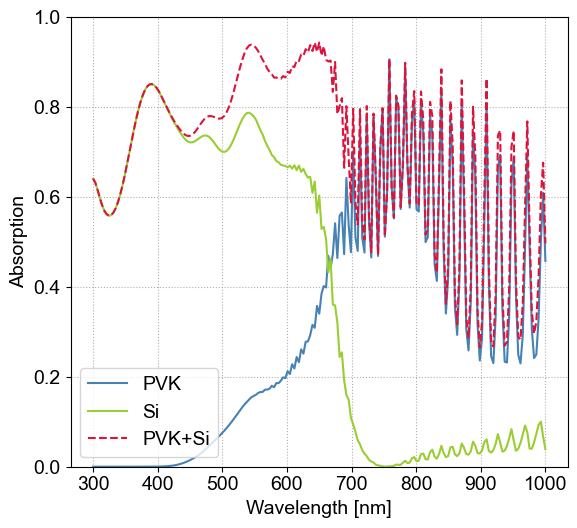

In [33]:
plt.figure(figsize=(6,5.5))
plt.plot(abs_si['lmb']*1e9, abs_si['abs'], c = 'steelblue', label = 'PVK')
plt.plot(abs_pvk['lmb']*1e9, abs_pvk['abs'], c = 'yellowgreen', label = 'Si')
plt.plot(abs_si['lmb']*1e9, abs_si['abs']+abs_pvk['abs'],'--', c = 'crimson', label = 'PVK+Si')
plt.ylim(0,1)
plt.grid(linestyle=':')
plt.legend()
plt.ylabel('Absorption')
plt.xlabel('Wavelength [nm]')
# plt.savefig(r'D:\CEMOP FDTD\Eva\bolsa\optimization\2t\optical_test\abs_spectra.svg', dpi = 300, bbox_inches = 'tight')

### Individual variable assessement

In [69]:
fdtd_file: str = r"D:\CEMOP FDTD\Eva\bolsa\optimization\2t\optical_test\2t_planar_tandem.fsp"

param_dict = {'tPerovskite': [0.2e-6, 0.7e-6],
              'tlayer': [0.0e-6, 0.4e-6],
              'tITO': [0.1e-6, 0.4e-6]}

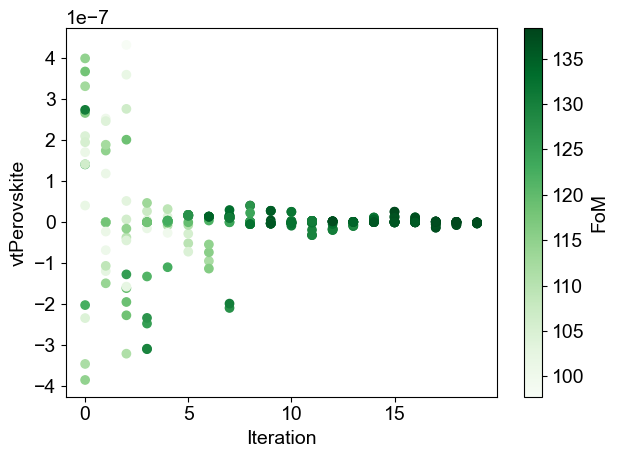

In [75]:
pso_iter_plt('vtPerovskite', 'D:\\CEMOP FDTD\\Eva\\bolsa\\optimization\\2t\\optical_test', 'Greens', savefig_name='vPerovskite.svg', alpha = 1)

### Dual variable assessment

#### PSO

Text(0.5, 0, 'Interlayer thickness [nm]')

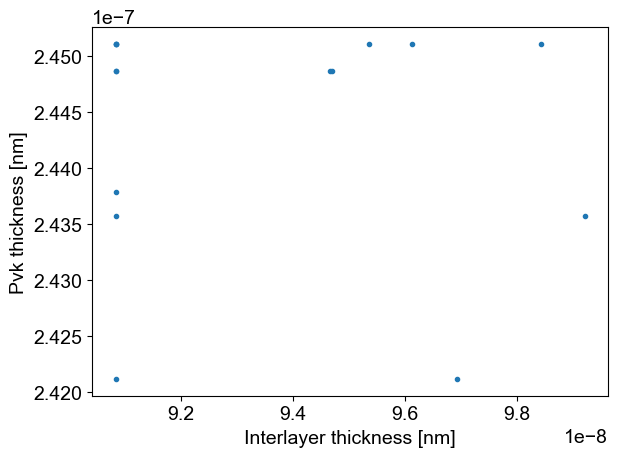

In [4]:
data_1 = pd.read_csv(r'D:\CEMOP FDTD\Eva\bolsa\optimization\2t\optical_test\pso_it020.csv', sep = '\s', engine= 'python')

plt.plot(data_1['tlayer'],data_1['tPerovskite'], '.')
plt.ylabel('Pvk thickness [nm]')
plt.xlabel('Interlayer thickness [nm]')

#### Sweep

In [7]:
data = pd.read_csv(r'D:\CEMOP FDTD\Eva\bolsa\sweep\planar\2t\optical\tPerovskite_tlayer_sweep.csv')
basefile = r"D:\CEMOP FDTD\Eva\bolsa\sweep\planar\2t\optical\tPerovskite_tlayer_sweep.csv"
def get_fom(jsc_si, jsc_pvk):
    fom = min(jsc_si,jsc_pvk)#(pce_si*100+pce_pvk*100)#/(1+abs(jsc_si-jsc_pvk))
    return fom

In [10]:
def plot_colormap(basefile, x_var, y_var, x_label, y_label, z_label):
    '''basefile: str of file path'''
    # INPUT DATA
    wide_data = pd.read_csv(basefile)

    # ORGANIZE DATA (X, Y AND Z AXIS) FOR .imshow
    x_list = list(wide_data[x_var].drop_duplicates()) # X AXIS
    y_list = list(wide_data[y_var].drop_duplicates()) # Y AXIS
    z = []

    for x in x_list:
        z_list = []
        for d in range(len(wide_data['jsc_si'])):
            if wide_data[x_var][d] == x:
                z_list.append(get_fom(abs(wide_data['jsc_si'][d]), abs(wide_data['jsc_pvk'][d])))
        z.append(z_list) # Z AXIS
     
    # COLOURMAP PLOTING
    fig, ax = plt.subplots()
    c = ax.imshow(z, cmap = 'hot', extent=[min(y_list)*1e9, max(y_list)*1e9, max(x_list)*1e9, min(x_list)*1e9], aspect = (max(y_list)- min(y_list))/(max(x_list)- min(x_list)), interpolation = 'quadric')
    cbar = fig.colorbar(c, ax=ax, label=z_label, ticks = np.linspace(min(np.array(z).flatten()), max(np.array(z).flatten()), 5))
    plt.ylabel(x_label)
    plt.xlabel(y_label)

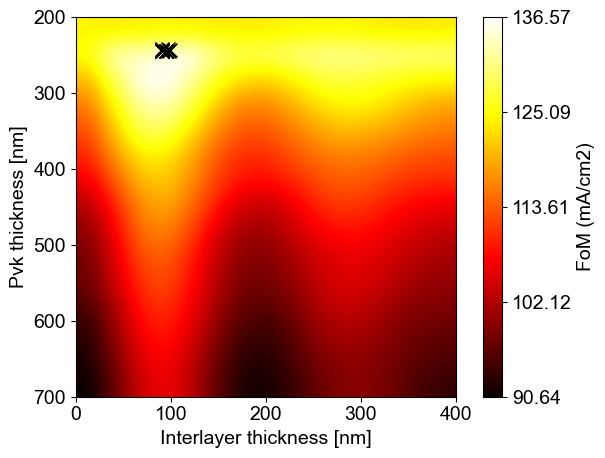

In [20]:
x_var = 'tPerovskite'
y_var = 'tlayer'
x_label = 'Pvk thickness [nm]'
y_label = 'Interlayer thickness [nm]'
z_label = 'FoM (mA/cm2)'
plot_colormap(basefile, x_var, y_var, x_label, y_label, z_label)
plt.plot(data_1['tlayer']*1e9,data_1['tPerovskite']*1e9, 'x', markersize = 10, c = "k")
# plt.savefig(r'D:\CEMOP FDTD\Eva\bolsa\optimization\2t\optical_test\fom_sweep_last_iteration.svg', dpi = 300, bbox_inches = 'tight')

